In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 788.1 kB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2, os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Activation,LSTM,Flatten,GRU,Conv2D, MaxPool2D,Reshape, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import os
# import cv2
# import numpy as np

# def MyIN_FuzzyFilt(in_image, no_lfdct):
#     # Convert the input image to grayscale
#     gray_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2GRAY)

#     # Convert the grayscale image to floating-point format
#     gray_float = np.float32(gray_image)

#     # Selecting low frequency DCT coefficients in zigzag manner
#     dct_mat = cv2.dct(gray_float)

#     dct_coef_zz = np.zeros(no_lfdct)
#     k = 0
#     max_of_ij_sum = int((1 + np.sqrt(1 + 8 * no_lfdct)) / 2)

#     for ijtotal in range(2, max_of_ij_sum + 1):
#         for i in range(1, max_of_ij_sum):
#             for j in range(1, max_of_ij_sum):
#                 if i + j == ijtotal:
#                     dct_coef_zz[k] = dct_mat[i, j]
#                     k += 1

#     # Generating fuzzy filter membership grades
#     a = np.arange(1, no_lfdct + 1)
#     ff_mem_grade = a / np.max(a)  # Linear Filter
#     ff_mem_grade[0] = 1  # Leaving first membership grade as one

#     if ff_mem_grade.size >= 3:
#         ff_mem_grade[1:3] = 0

#     # Multiplying grades with low freq DCT coeff.
#     dct_coef_modified = dct_coef_zz * ff_mem_grade

#     k = 0
#     for ijtotal in range(2, max_of_ij_sum + 1):
#         for i in range(1, max_of_ij_sum):
#             for j in range(1, max_of_ij_sum):
#                 if i + j == ijtotal:
#                     dct_mat[i, j] = dct_coef_modified[k]
#                     k += 1

#     # Apply the inverse DCT
#     IlluNorm_Image = cv2.idct(dct_mat)

#     # Convert the image back to 8-bit format
#     IlluNorm_Image = np.uint8(IlluNorm_Image)

#     return IlluNorm_Image

# # # Path to parent folder containing subfolders with images
# # parent_folder = 'E:/CFSL/datasets/My_CroppedYale38'

# # # Loop through each subfolder
# # for folder_name in os.listdir(parent_folder):
# #     subfolder_path = os.path.join(parent_folder, folder_name)

# #     # Create a new folder to store processed images
# #     output_folder = os.path.join(parent_folder, folder_name + '_processed')
# #     os.makedirs(output_folder, exist_ok=True)

# #     # Loop through each image file in the subfolder
# #     for file_name in os.listdir(subfolder_path):
# #         image_path = os.path.join(subfolder_path, file_name)

# #         # Read the image using OpenCV
# #         in_image = cv2.imread(image_path)

# #         # Call the MyIN_FuzzyFilt function with the image
# #         no_lfdct = 10  # Specify the desired number of low frequency DCT coefficients
# #         IlluNorm_Image = MyIN_FuzzyFilt(in_image, no_lfdct)

# #         # Perform further operations or save the output image
# #         # For example, you can save the normalized image with a unique name
# #         output_file = os.path.join(output_folder, 'normalized_' + file_name)
# #         cv2.imwrite(output_file, IlluNorm_Image)


In [ ]:
import numpy as np
from scipy.fftpack import dct, idct
from skimage.exposure import equalize_hist

def MyIN_FuzzyFilt(in_image, no_lfdct):
    # Applying histogram equalization
    histeq_image = equalize_hist(in_image)

    # Applying DCT to the image
    dct_mat = dct(histeq_image, norm='ortho')

    # Selecting low frequency DCT coefficients in zigzag manner
    max_of_ij_sum = int((1 + np.sqrt(1 + 8 * no_lfdct)) / 2)
    dct_coef_zz = []
    for ijtotal in range(2, max_of_ij_sum + 1):
        for i in range(1, max_of_ij_sum):
            for j in range(1, max_of_ij_sum):
                if i + j == ijtotal:
                    dct_coef_zz.append(dct_mat[i, j])

    # Generating fuzzy filter membership grades
    a = np.arange(1, no_lfdct + 1)
    ff_mem_grade = a / np.max(a)  # Linear Filter

    # Adjusting the size of dct_coef_zz to match ff_mem_grade
    dct_coef_zz = np.array(dct_coef_zz)[:no_lfdct]

    # Reshaping ff_mem_grade to match the shape of dct_coef_zz
    ff_mem_grade = ff_mem_grade.reshape(-1, 1)

    # Modifying the low frequency DCT coefficients using fuzzy filter
    dct_coef_modified = dct_coef_zz * ff_mem_grade

    # Performing unzigzagging
    k = 0
    for ijtotal in range(2, max_of_ij_sum + 1):
        for i in range(1, max_of_ij_sum):
            for j in range(1, max_of_ij_sum):
                if i + j == ijtotal:
                    dct_mat[i, j] = dct_coef_modified[k]
                    k += 1

    # Applying inverse DCT
    IlluNorm_Image = idct(dct_mat, norm='ortho')

    return IlluNorm_Image


In [ ]:
# Path to parent folder containing subfolders with images
parent_folder = "/content/drive/MyDrive/ExperimentalAnalysis/My_CroppedYale38"

# Initialize a dictionary to store processed images
processed_images = {}
x=[]
y=[]
i=0
# Loop through each subfolder
for folder_name in os.listdir(parent_folder):
    subfolder_path = os.path.join(parent_folder, folder_name)

    # Loop through each image file in the subfolder
    for file_name in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file_name)

        # Read the image using OpenCV
        in_image = cv2.imread(image_path)

        # Call the MyIN_FuzzyFilt function with the image
        no_lfdct = 10  # Specify the desired number of low frequency DCT coefficients
        IlluNorm_Image = MyIN_FuzzyFilt(in_image, no_lfdct)

        # Store the processed image in the dictionary
        processed_images[image_path] = IlluNorm_Image

        x.append(IlluNorm_Image)
        y.append(i)
    i += 1


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [ ]:
x=np.asarray(x)
y=np.asarray(y)

In [ ]:
x.shape

(2414, 192, 168, 3)

In [ ]:
y.shape


(2414,)

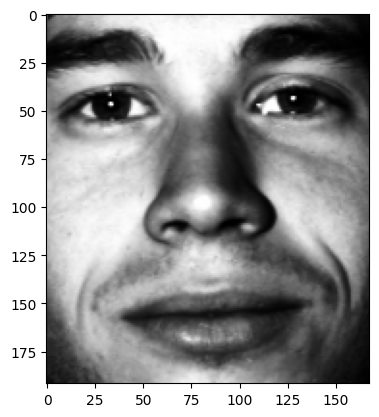

In [ ]:
plt.imshow(x[0])

In [ ]:
#x = x / 255.0

In [ ]:
# from sklearn.model_selection import train_test_split
# # train_images,test_images,train_labels,test_labels=train_test_split(x,y,test_size=0.20)

# train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.20, stratify=y)

In [ ]:
train_images2 = []
train_labels2 = []
test_images2 = []
test_labels2 = []

for label in set(y):
    label_indices = [i for i, l in enumerate(y) if l == label]
    label_images = [x[i] for i in label_indices]
    label_labels = [y[i] for i in label_indices]

    train_images2.extend(label_images[:51])
    train_labels2.extend(label_labels[:51])
    test_images2.extend(label_images[51:])
    test_labels2.extend(label_labels[51:])

In [ ]:
# import numpy as np

# unique_labels, label_counts = np.unique(test_labels2, return_counts=True)

# for label, count in zip(unique_labels, label_counts):
#     print(f"Label: {label}, Count: {count}")

In [ ]:
# import numpy as np

# unique_labels, label_counts = np.unique(train_labels2, return_counts=True)

# for label, count in zip(unique_labels, label_counts):
#     print(f"Label: {label}, Count: {count}")

In [ ]:
# import numpy as np

# unique_labels, label_counts = np.unique(y, return_counts=True)

# for label, count in zip(unique_labels, label_counts):
#     print(f"Label: {label}, Count: {count}")

In [ ]:
train_images = train_images2
train_labels = train_labels2
test_images = test_images2
test_labels = test_labels2

In [ ]:
train_images=np.asarray(train_images)
train_labels=np.asarray(train_labels)
test_images=np.asarray(test_images)
test_labels=np.asarray(test_labels)

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1938, 192, 168, 3)
(1938,)
(476, 192, 168, 3)
(476,)


In [ ]:
model = Sequential()
#train_images = tf.cast(train_images, tf.float32)
activation_function = tf.keras.layers.LeakyReLU()
model.add(Input((192, 168, 3)))
model.add(Conv2D(32, (3,3), strides=(2,2), activation=activation_function))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
# model.add(Conv2D(32, (3,3), strides=(1,1), activation=activation_function))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3), strides=(2,2), activation=activation_function))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# model.add(Conv2D(64, (3,3), strides=(1,1), activation=activation_function))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3), strides=(2,2), activation=activation_function))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# model.add(Conv2D(128, (3,3), strides=(1,1), activation=activation_function))
# model.add(MaxPool2D(pool_size=(2,2),strides=2))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dropout(0.3))
model.add(Reshape((-1,128)))
model.add(LSTM(64, activation='tanh', return_sequences=True ))
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# model.add(Dense(512, activation="tanh"))
model.add(Dense(256, activation="tanh"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation="tanh"))
model.add(Dense(38, activation="softmax"))

In [ ]:
model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 83, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 41, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 41, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 10, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 11, 10, 64)        2

In [ ]:
adam=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=500, validation_data=(test_images, test_labels), batch_size=32, validation_split=0.20)

Epoch 1/500
61/61 [==============================] - 22s 75ms/step - loss: 3.8206 - accuracy: 0.0470 - val_loss: 3.6368 - val_accuracy: 0.0273
Epoch 2/500
61/61 [==============================] - 2s 31ms/step - loss: 3.2974 - accuracy: 0.1011 - val_loss: 3.7297 - val_accuracy: 0.0273
Epoch 3/500
61/61 [==============================] - 1s 24ms/step - loss: 2.7901 - accuracy: 0.2090 - val_loss: 3.6628 - val_accuracy: 0.0777
Epoch 4/500
61/61 [==============================] - 2s 25ms/step - loss: 2.2878 - accuracy: 0.3215 - val_loss: 3.1079 - val_accuracy: 0.1597
Epoch 5/500
61/61 [==============================] - 1s 22ms/step - loss: 1.8908 - accuracy: 0.4510 - val_loss: 2.0946 - val_accuracy: 0.3676
Epoch 6/500
61/61 [==============================] - 1s 22ms/step - loss: 1.5386 - accuracy: 0.5382 - val_loss: 1.6102 - val_accuracy: 0.5231
Epoch 7/500
61/61 [==============================] - 1s 22ms/step - loss: 1.2520 - accuracy: 0.6269 - val_loss: 0.9284 - val_accuracy: 0.7395
Epoch

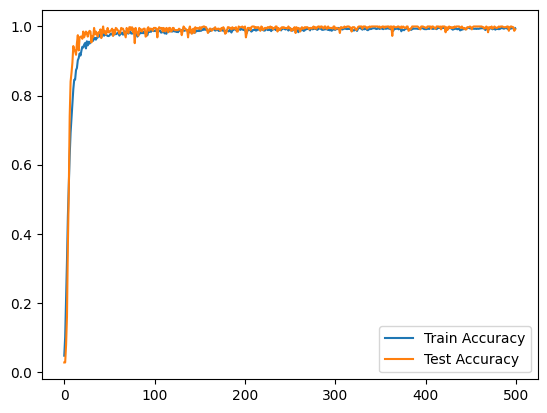

In [ ]:
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

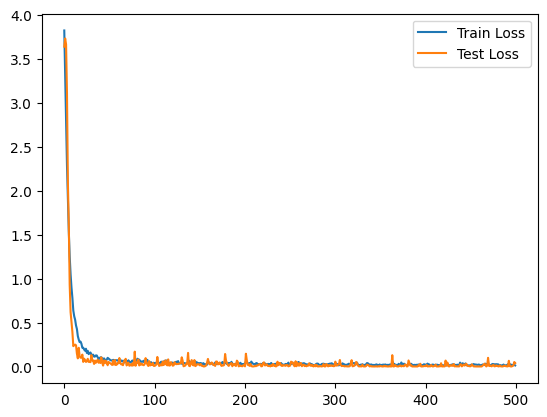

In [ ]:
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

In [ ]:
# y_pred = model.predict(test_images)
# y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# test_labels_numpy = test_labels.astype(int)
# precision = precision_score(test_labels_numpy, y_pred_classes, average='weighted')
# recall = recall_score(test_labels_numpy, y_pred_classes, average='weighted')
# f1 = f1_score(test_labels_numpy, y_pred_classes, average='weighted')
# accuracy = model.evaluate(test_images, test_labels)[1]

# #print(f"Learning Rate: {lr}, Batch Size: {batch_size}")
# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
# print("----------------------------------")


import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# # Make predictions on the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# # Convert test labels to numpy array
test_labels_numpy = test_labels.astype(int)

# # Calculate metrics
accuracy = accuracy_score(test_labels_numpy, y_pred_classes)
precision = precision_score(test_labels_numpy, y_pred_classes, average='weighted')
recall = recall_score(test_labels_numpy, y_pred_classes, average='weighted')
f1 = f1_score(test_labels_numpy, y_pred_classes, average='weighted')


# Print the metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



15/15 [==============================] - 1s 9ms/step
Accuracy: 0.9915966386554622
Precision: 0.9929284213685474
Recall: 0.9915966386554622
F1-score: 0.9915048311511845


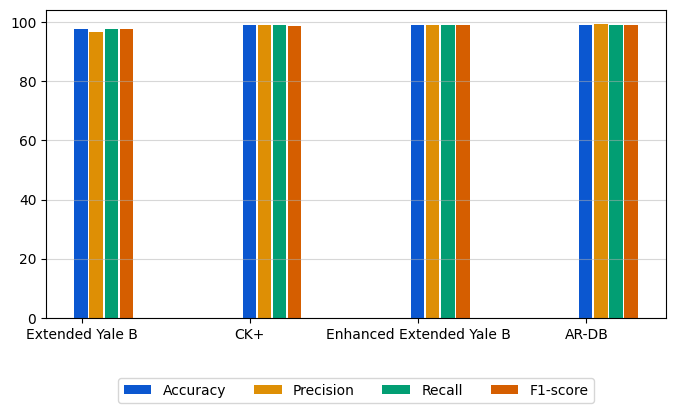

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data in descending order of accuracy
datasets = ["Extended Yale B", "CK+", "Enhanced Extended Yale B", "AR-DB"]
accuracy = [97.68, 98.99, 99.16, 99.23]
precision = [96.69, 99.06, 99.29, 99.40]
recall = [97.93, 98.99, 99.15, 99.23]
f1_score = [97.68, 98.96, 99.15, 99.22]

# Set width of the bars
barWidth = 0.08

# Set position of bar on X axis
r1 = np.arange(len(accuracy))
r2 = [x + barWidth + 0.01 for x in r1]
r3 = [x + barWidth + 0.01 for x in r2]
r4 = [x + barWidth + 0.01 for x in r3]

# Plotting
plt.figure(figsize=(8, 4))

plt.bar(r1, accuracy, color='#0B57D0', width=barWidth, edgecolor='white', label='Accuracy', linewidth=-0)  # Golden
plt.bar(r2, precision, color='#DE8F05', width=barWidth, edgecolor='white', label='Precision', linewidth=0)  # Blue
plt.bar(r3, recall, color='#029E73', width=barWidth, edgecolor='white', label='Recall', linewidth=0)  # Turquoise
plt.bar(r4, f1_score, color='#D55E00', width=barWidth, edgecolor='white', label='F1-score', linewidth=0)  # Maroon

# Adding grid
plt.grid(axis='y', linestyle='-', alpha=0.5)

# Adding legend at the bottom
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)

# Adding dataset names on x-axis with minimal distance
plt.xticks([r + 0.05 * barWidth for r in range(len(accuracy))], datasets)

# Display the plot
plt.show()


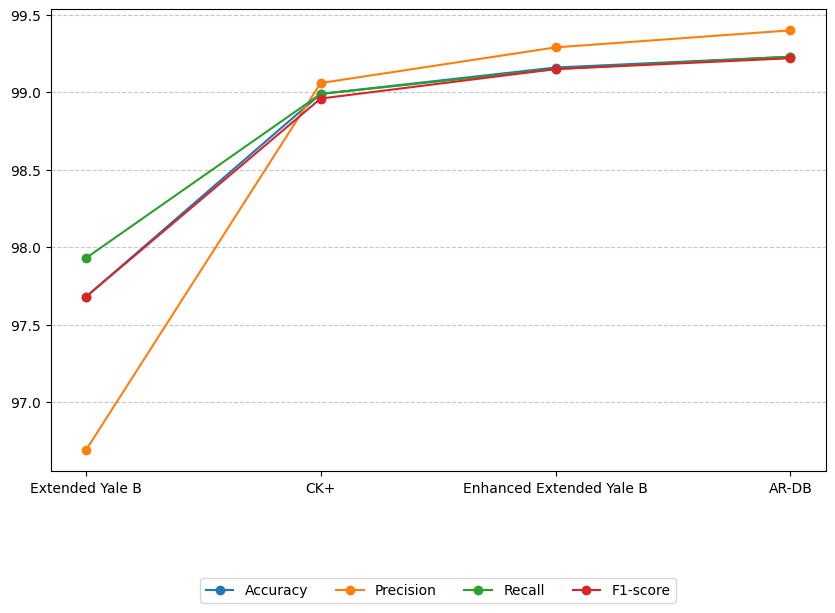

In [8]:
import matplotlib.pyplot as plt

# Data
datasets = ["Extended Yale B", "CK+", "Enhanced Extended Yale B", "AR-DB"]
accuracy = [97.68, 98.99, 99.16, 99.23]
precision = [96.69, 99.06, 99.29, 99.40]
recall = [97.93, 98.99, 99.15, 99.23]
f1_score = [97.68, 98.96, 99.15, 99.22]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(datasets, accuracy, marker='o', label='Accuracy')
plt.plot(datasets, precision, marker='o', label='Precision')
plt.plot(datasets, recall, marker='o', label='Recall')
plt.plot(datasets, f1_score, marker='o', label='F1-score')

# # Adding labels and title
# plt.xlabel('Datasets', fontweight='bold', fontsize=12)
# plt.ylabel('Percentage', fontweight='bold', fontsize=12)
# plt.title('Performance Metrics for Different Datasets', fontsize=14)

# Adding legend at the bottom
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)

# Adding grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()
